In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import projpath
data_folder = os.path.join(projpath.data_dir, 'H021')
mvc_data_folder = os.path.join(projpath.data_dir, 'H021 MVC')

# Read data

### Read MVC data

In [2]:
collect_mvc_signals = {}
for f in [f for f in os.listdir(mvc_data_folder) if f.endswith('TXT')]:
    with open(os.path.join(mvc_data_folder, f)) as fp:
        lines = fp.readlines()

        ## get muscle names
        muscle_names = lines[1].replace('\n', '').split('\t')
        muscle_names = [e for e in muscle_names if e != '']
        n_muscle = len(muscle_names)
        print(f'file = {f:15}, n_muscle = {n_muscle}, muscles={muscle_names}')

        mvc_signals = []
        for line in lines[2:]:
            row = line.replace('\n', '').replace('\t\t', '\t').split('\t')
            mvc_signals.append([float(row[index]) for index in range(1, 2 * n_muscle + 1, 2)])
        mvc_signals = np.array(mvc_signals)
        for i in range(n_muscle):
            collect_mvc_signals[muscle_names[i]] = mvc_signals[:,i] / 1e6   ## mu-V -> V

file = Gast.TXT       , n_muscle = 4, muscles=['L.Med. Gastro', 'L.Lat. Gastro', 'R.Med. Gastro', 'R.Lat. Gastro']
file = L Glut Max.TXT , n_muscle = 1, muscles=['L.Glut.Max.']
file = L Glut Mid.TXT , n_muscle = 1, muscles=['L.Glut.Med.']
file = L Ham.TXT      , n_muscle = 2, muscles=['L.Semitend.', 'L.Biceps Fem.']
file = L Quad.TXT     , n_muscle = 2, muscles=['L.Vmo', 'L.Vlo']
file = R Glut Max.TXT , n_muscle = 1, muscles=['R.Glut.Max.']
file = R Glut Med.TXT , n_muscle = 1, muscles=['R.Glut.Med.']
file = R Ham.TXT      , n_muscle = 2, muscles=['R.Semitend.', 'R.Biceps Fem.']
file = R Quad.TXT     , n_muscle = 2, muscles=['R.Vmo', 'R.Vlo']


In [3]:
for muscle in collect_mvc_signals:
    print(f'muscle={muscle:13}, shape={collect_mvc_signals[muscle].shape}')

muscle=L.Med. Gastro, shape=(46600,)
muscle=L.Lat. Gastro, shape=(46600,)
muscle=R.Med. Gastro, shape=(46600,)
muscle=R.Lat. Gastro, shape=(46600,)
muscle=L.Glut.Max.  , shape=(31600,)
muscle=L.Glut.Med.  , shape=(31800,)
muscle=L.Semitend.  , shape=(31000,)
muscle=L.Biceps Fem., shape=(31000,)
muscle=L.Vmo        , shape=(31800,)
muscle=L.Vlo        , shape=(31800,)
muscle=R.Glut.Max.  , shape=(37000,)
muscle=R.Glut.Med.  , shape=(26000,)
muscle=R.Semitend.  , shape=(29600,)
muscle=R.Biceps Fem., shape=(29600,)
muscle=R.Vmo        , shape=(28200,)
muscle=R.Vlo        , shape=(28200,)


### Read trial data

In [4]:
trial_gain = 1000
class TrialData:
    def __init__(self, folder, filename):
        self.read_raw_data_file(folder, filename)
        
    def read_raw_data_file(self, folder, filename):
        self.filename = filename
        self.signals = []
        
        with open(os.path.join(folder, filename)) as fp:
            for line in fp:
                line = line.replace('\n', '')
                items = line.split('\t')
                
                if items[0] == 'NO_OF_SAMPLES':
                    self.num_sample = int(items[1])
                    
                elif items[0] == 'TOT_NO_OF_CHAN':
                    self.num_channel = int(items[1])
                    
                elif items[0] == 'FREQUENCY':
                    self.frequency = float(items[1])
                    
                elif items[0] == 'NO_OF_CALC_CHAN':
                        self.num_calc_channel = int(items[1])
                        
                elif items[0] == 'TIME_STAMP':
                    self.timestamp = items[1]
                    self.timestamp_2nd_val = float(items[2])
                    
                elif items[0] == 'FIRST_SAMPLE':
                    self.first_sample = int(items[1])
                    
                elif items[0] == 'DESCRIPTION':
                    pass
                
                elif items[0] == 'DATA_INCLUDED':
                    self.data_included = items[1]
                    
                elif items[0] == 'CHANNEL_NAMES':
                    self.channel_names = items[1:]
                    
                elif items[0] == 'CHANNEL_GAIN':
                    self.channel_gains = [float(e) for e in items[1:]]
                    
                elif items[0] == 'FP_LOCATION':
                    pass
                
                elif items[0] == 'FP_CAL':
                    pass
                
                elif items[0] == 'FP_GAIN':
                    pass
                
                elif len(items) >= self.num_channel:
                    self.signals.append([float(e) / trial_gain for e in items[:self.num_channel]])
                    
            self.signals = np.array(self.signals).transpose()

In [5]:
input_files = [f for f in os.listdir(data_folder) if f.endswith('.tsv')]
num_trial = len(input_files)

data = [None] * num_trial
for i in range(num_trial):
    data[i] = TrialData(data_folder, input_files[i])

### Combine MVC and trial

In [6]:
class MuscleData:
    def __init__(self, channel_idx, channel_name, num_trial):
        self.mvc_signal = None
        self.mvc = 0
        
        self.channel_idx = channel_idx
        self.channel_name = channel_name
        self.muscle_name = self.channel_name.split('_')[1]
        self.num_trial = num_trial
        self.orig_signals = [None] * num_trial
        self.processed_signals = [None] * num_trial
        
    def set_mvc_signal(self, mvc_signal):
        self.mvc_signal = mvc_signal
        
    def set_mvc(self, mvc):
        self.mvc = mvc
    
    def set_orig_signal(self, orig_signal, trial_idx):
        self.orig_signals[trial_idx] = orig_signal
        
    def set_processed_signal(self, processed_signal, trial_idx):
        self.processed_signals[trial_idx] = processed_signal

In [7]:
frequency = data[0].frequency

start_channel_idx = 16
num_muscle = 16
muscle_data = [None] * num_muscle
for c in range(num_muscle):
    channel_idx = start_channel_idx + c
    muscle_data[c] = MuscleData(channel_idx, data[0].channel_names[channel_idx], num_trial)
    
    for i in range(num_trial):
        x = data[i].signals[channel_idx].copy()
        muscle_data[c].set_orig_signal(x, i)
        
        mvc = collect_mvc_signals[muscle_data[c].muscle_name].copy()
        muscle_data[c].set_mvc_signal(mvc)

# EMG Processing functions

In [8]:
def remove_dc_offset(x):
    return x - np.mean(x)

def apply_bandpass_filter(x, frequency, order=2, cutoff_fq_lo=30, cutoff_fq_hi=500):
    b, a = signal.butter(order, [cutoff_fq_lo, cutoff_fq_hi], btype='bandpass', analog=False, fs=frequency)
    return signal.filtfilt(b, a, x)

def apply_full_wave_rectify(x):
    return abs(x)

def apply_linear_envelope(x, frequency, order=2, cutoff_fq_lo=6):
    b, a = signal.butter(order, cutoff_fq_lo, btype='lowpass', analog=False, fs=frequency)
    return signal.filtfilt(b, a, x)

def cut_off_end_frames(x, n_end_frames_cut=30):
    if len(x) > 2 * n_end_frames_cut:
        return x[n_end_frames_cut:(-n_end_frames_cut)]
    else:
        return x

# Process MVC signal

### Observe

In [9]:
muscle_idx = 15
x_mvc = muscle_data[muscle_idx].mvc_signal.copy()

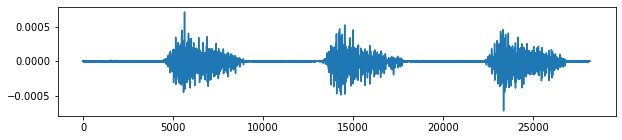

In [10]:
plt.figure(figsize=(10,2))
plt.plot(x_mvc, '-');

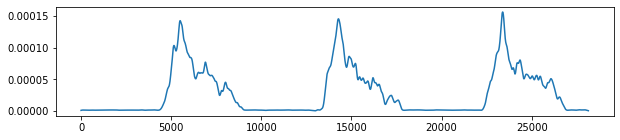

In [11]:
x_mvc1 = remove_dc_offset(x_mvc)
x_mvc2 = apply_bandpass_filter(x_mvc1, frequency)
x_mvc3 = apply_full_wave_rectify(x_mvc2)
x_mvc4 = apply_linear_envelope(x_mvc3, frequency)
x_mvc5 = cut_off_end_frames(x_mvc4)
plt.figure(figsize=(10,2))
plt.plot(x_mvc5, '-');

In [12]:
mvc = np.max(x_mvc5)
print(f'mvc = {mvc}')

mvc = 0.00015600756674408788


In [13]:
def process_mvc_signal_and_calculate_mvc(x, frequency):
    x1 = remove_dc_offset(x)
    x2 = apply_bandpass_filter(x1, frequency)
    x3 = apply_full_wave_rectify(x2)
    x4 = apply_linear_envelope(x3, frequency)
    x5 = cut_off_end_frames(x4)
    
    ## calculate mvc
    mvc = np.max(x5)
    loc = np.where(x5 == mvc)
    return mvc, loc, x5

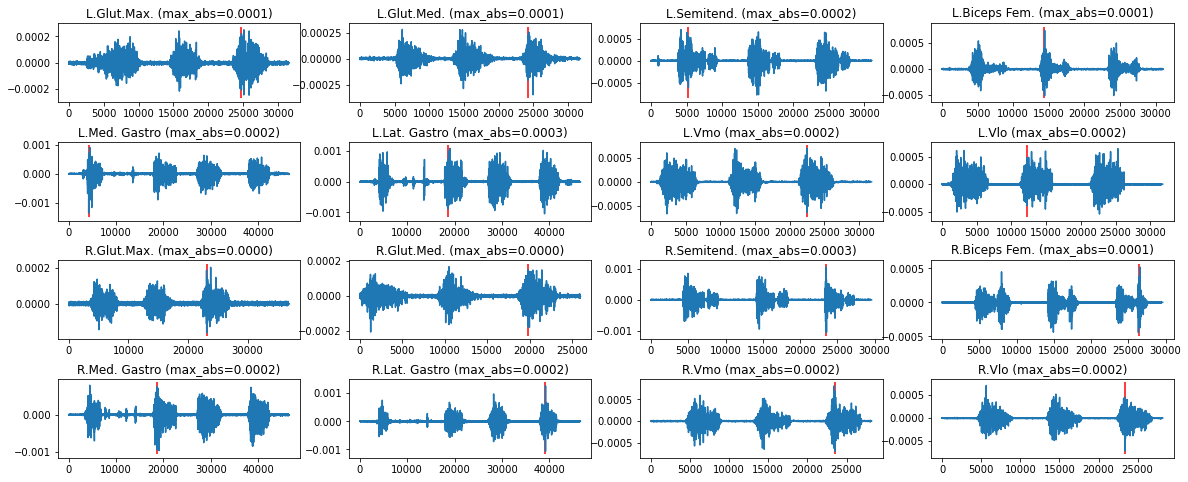

In [14]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
muscle_idx = 0
for r in range(nrows):
    for c in range(ncols):
        x_mvc = muscle_data[muscle_idx].mvc_signal.copy()
        mvc, loc, _ = process_mvc_signal_and_calculate_mvc(x_mvc, frequency)
        axes[r][c].plot(x_mvc, '-');
        axes[r][c].vlines(loc[0], np.min(x_mvc) * 1.1, np.max(x_mvc) * 1.1, 'r');
        axes[r][c].set_title(f'{muscle_data[muscle_idx].muscle_name} (max_abs={mvc:.4f})')
        muscle_idx += 1

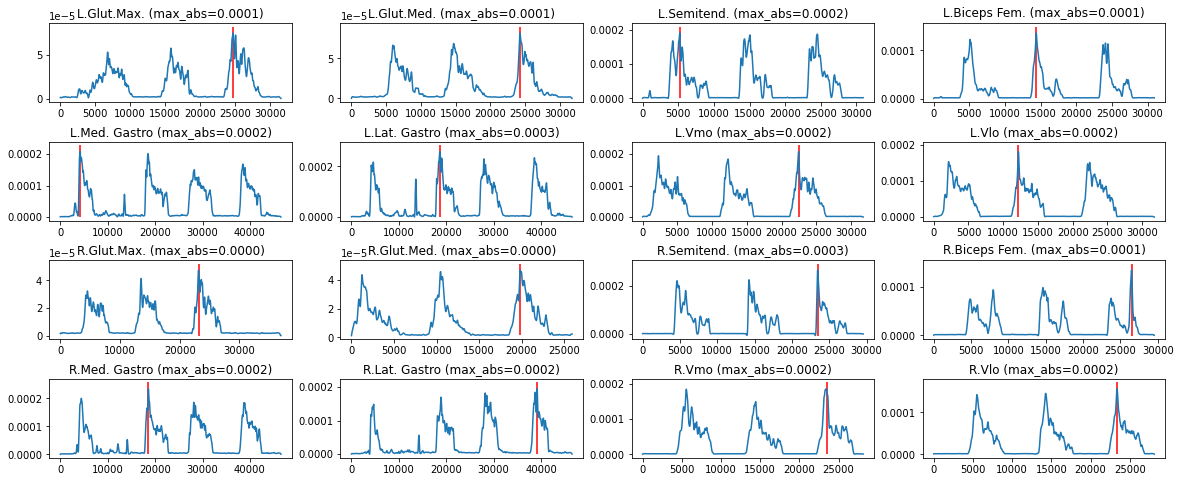

In [15]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
muscle_idx = 0
for r in range(nrows):
    for c in range(ncols):
        x_mvc = muscle_data[muscle_idx].mvc_signal.copy()
        mvc, loc, x_mvc_processed = process_mvc_signal_and_calculate_mvc(x_mvc, frequency)
        axes[r][c].plot(x_mvc_processed, '-');
        axes[r][c].vlines(loc[0], np.min(x_mvc_processed) * 1.1, np.max(x_mvc_processed) * 1.1, 'r');
        axes[r][c].set_title(f'{muscle_data[muscle_idx].muscle_name} (max_abs={mvc:.4f})')
        muscle_idx += 1

### Set mvc value to MuscleData

In [16]:
for c in range(num_muscle):
    x_mvc = muscle_data[c].mvc_signal.copy()
    mvc, _, _ = process_mvc_signal_and_calculate_mvc(x_mvc, frequency)
    muscle_data[c].set_mvc(mvc)

# Process trial signal

### Observe

In [17]:
muscle_idx = 3
trial_idx = 0

print(f'channel name = {muscle_data[muscle_idx].channel_name}')
print(f'muscle_name = {muscle_data[muscle_idx].muscle_name}')
print(f'sample frequency = {frequency}')
x = muscle_data[muscle_idx].orig_signals[trial_idx].copy()
print(f'sample size = {x.shape[0]}')

channel name = 20_L.Biceps Fem.
muscle_name = L.Biceps Fem.
sample frequency = 2000.0
sample size = 9050


In [18]:
time_steps = [e / frequency for e in range(len(x))]
first_sample = data[i].first_sample / frequency

In [19]:
frequency

2000.0

#### 0. Original signal

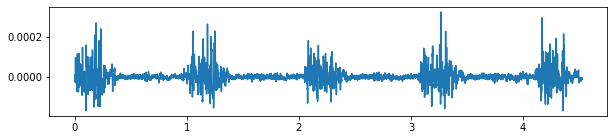

In [20]:
plt.figure(figsize=(10,2))
plt.plot(time_steps, x, '-')
# plt.vlines(first_sample, np.min(x), np.max(x), 'c');

#### 1. Remove DC offset

7.392853038674032e-07


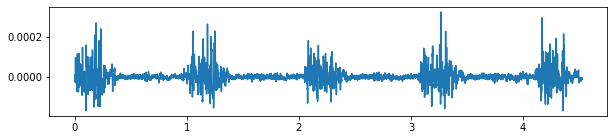

In [21]:
print(np.mean(x))
x1 = x - np.mean(x)
plt.figure(figsize=(10,2))
plt.plot(time_steps, x1, '-')
# plt.vlines(first_sample, np.min(x1), np.max(x1), 'c');

#### 2. Bandpass filter

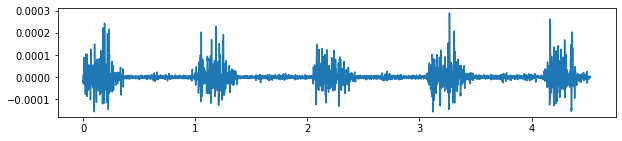

In [22]:
order = 2
cutoff_fq_lo, cutoff_fq_hi = 30, 500
b, a = signal.butter(order, [cutoff_fq_lo, cutoff_fq_hi], btype='bandpass', analog=False, fs=frequency)
# x2 = signal.lfilter(b, a, x1)
x2 = signal.filtfilt(b, a, x1) #dual pass
## ref: https://dsp.stackexchange.com/questions/19084/applying-filter-in-scipy-signal-use-lfilter-or-filtfilt
plt.figure(figsize=(10,2))
plt.plot(time_steps, x2, '-')
# plt.vlines(first_sample, np.min(x2), np.max(x2), 'c');

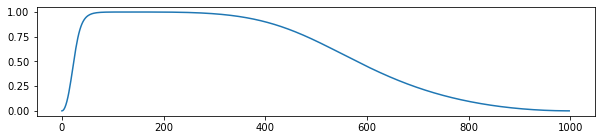

In [23]:
w, h = signal.freqz(b, a, fs=frequency)
plt.figure(figsize=(10,2))
plt.plot(w, abs(h));

#### 3. Full-wave rectify

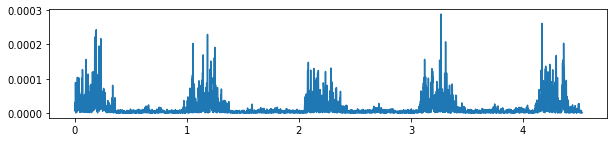

In [24]:
x3 = abs(x2)
plt.figure(figsize=(10,2))
plt.plot(time_steps, x3, '-')
# plt.vlines(first_sample, np.min(x3), np.max(x3), 'c');

#### 4. Linear envelope

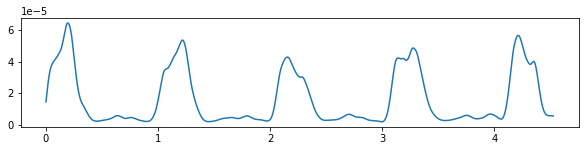

In [25]:
le_order = 2
le_cutoff_fq_lo = 6
b, a = signal.butter(le_order, le_cutoff_fq_lo, btype='lowpass', analog=False, fs=frequency)
x4 = signal.filtfilt(b, a, x3)
plt.figure(figsize=(10,2))
plt.plot(time_steps, x4, '-')
# plt.vlines(first_sample, np.min(x4), np.max(x4), 'c');

#### 5. (Cut off end frames)

9050 9050
8990 8990


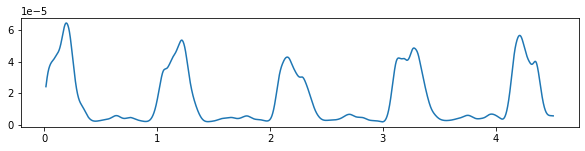

In [26]:
n_end_frames_cut = 30
x5 = x4
print(len(time_steps), len(x5))
if len(x5) > 2 * n_end_frames_cut:
    time_steps = time_steps[n_end_frames_cut:(-n_end_frames_cut)]
    x5 = x5[n_end_frames_cut:(-n_end_frames_cut)]
print(len(time_steps), len(x5))
plt.figure(figsize=(10,2))
plt.plot(time_steps, x5, '-')
# plt.vlines(first_sample, np.min(x5), np.max(x5), 'c');

#### 6. Amplitude normalization using MVC (maximal voluntary contraction)

mvc = 0.00013586660505201373


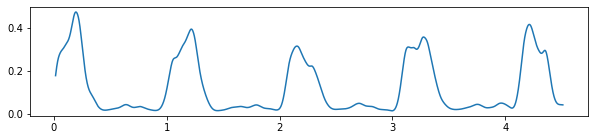

In [27]:
mvc = muscle_data[muscle_idx].mvc
print(f'mvc = {mvc}')
x6 = x5 / mvc
plt.figure(figsize=(10,2))
plt.plot(time_steps, x6, '-')
# plt.vlines(first_sample, np.min(x6), np.max(x6), 'c');

#### 7. Segmentation (timestamps of gait cycles from motion videos)

#### 8. Time normalization

### Set processed signal to MuscleData

In [28]:
def process_trial_signal(x, frequency, mvc):
    x1 = remove_dc_offset(x)
    x2 = apply_bandpass_filter(x1, frequency)
    x3 = apply_full_wave_rectify(x2)
    x4 = apply_linear_envelope(x3, frequency)
    x5 = cut_off_end_frames(x4)
    x6 = x5 / mvc
    return x6

In [29]:
for c in range(num_muscle):
    mvc = muscle_data[c].mvc
    
    for i in range(num_trial):
        x = muscle_data[c].orig_signals[i].copy()
        processed_signal = process_trial_signal(x, frequency, mvc)
        muscle_data[c].set_processed_signal(processed_signal, i)

# Visualize processed signals

In [30]:
collect_max = []
for c in range(num_muscle):
    for i in range(num_trial):
        sig_max = np.max(muscle_data[c].processed_signals[i])
        collect_max.append(sig_max)
print(f'overall max_max = {np.max(collect_max):.3f}, overall min_max = {np.min(collect_max):.3f}')

overall max_max = 0.988, overall min_max = 0.171


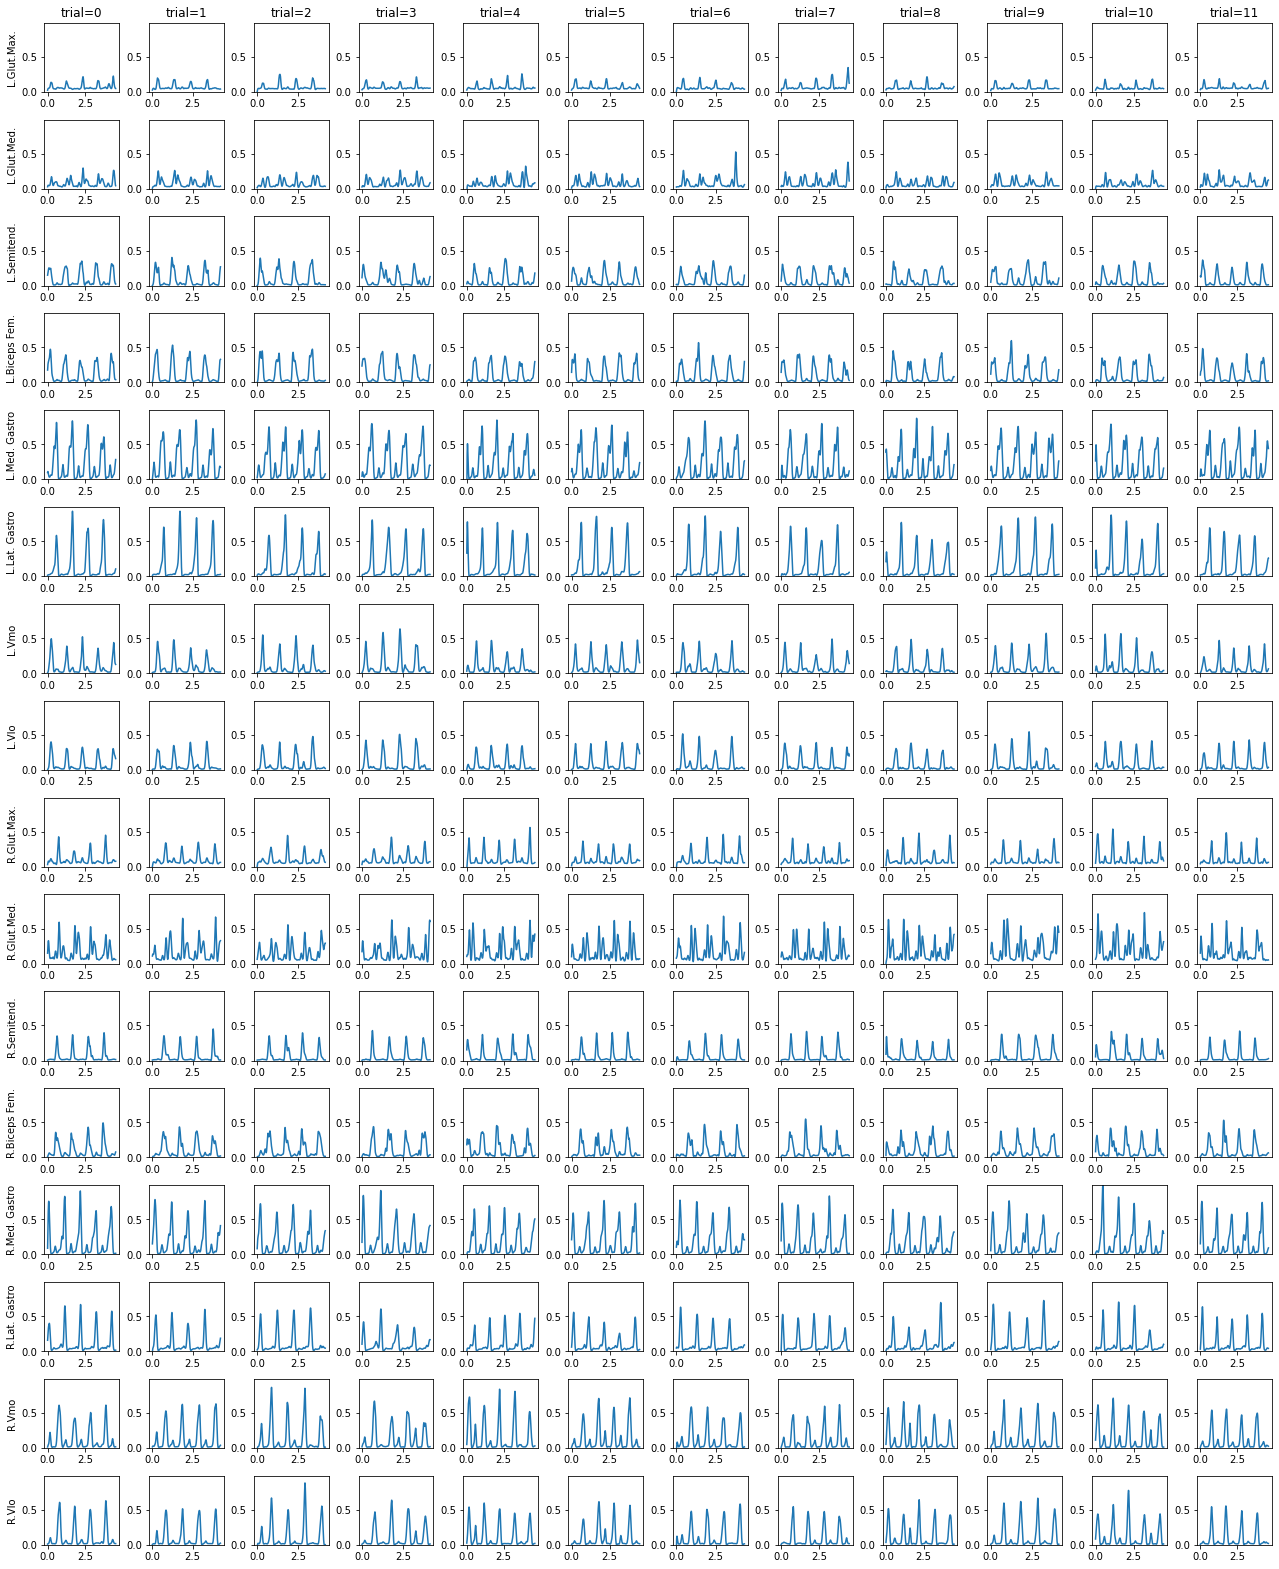

In [31]:
ymin, ymax = 0, np.max(collect_max)

nrows, ncols = num_muscle, num_trial
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 28))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for r in range(nrows):
    for c in range(ncols):
        y = muscle_data[r].processed_signals[c]
        time_steps = [e / frequency for e in range(len(y))]
        first_sample = data[c].first_sample / frequency
        axes[r][c].plot(time_steps, y, '-');
        axes[r][c].set_ylim([ymin, ymax]);
        # axes[r][c].vlines(first_sample, ymin, ymax, 'c');
        if r == 0:
            axes[r][c].set_title('trial={}'.format(c))
        if c == 0:
            axes[r][c].set_ylabel(muscle_data[r].muscle_name)